[paper](https://www.researchgate.net/publication/224839719_An_Analysis_of_Transformations_with_Discussion)

[StackExchange: llf of Box-Cox transform](https://stats.stackexchange.com/questions/261380/how-do-i-get-the-box-cox-log-likelihood-using-the-jacobian)

[Box-Cox Transformations: An Overview](https://www.ime.usp.br/~abe/lista/pdfm9cJKUmFZp.pdf)

[scipy code](https://github.com/scipy/scipy/blob/master/scipy/stats/morestats.py#L819)

[scipy API ref](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html#scipy.stats.boxcox)

[Concept: Korean](https://freshrimpsushi.github.io/posts/box-cox-transformation/)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from scipy.stats import boxcox, boxcox_llf, boxcox_normmax, f_oneway, shapiro, probplot
from scipy.optimize import brent
from scipy.special import ndtri

# Load data

In [3]:
data = load_boston()

In [4]:
X = data['data']
y = data['target']

In [5]:
data['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

# EDA

In [196]:
corr = []
for col in range(X.shape[1]):
    corr.append(pearsonr(y, X[:,col])[0])
    print(str(col).zfill(2), np.unique(X[:,col]).size, corr[-1])

00 504 -0.3883046085868116
01 26 0.36044534245054327
02 76 -0.48372516002837296
03 2 0.17526017719029846
04 81 -0.4273207723732826
05 446 0.6953599470715395
06 356 -0.37695456500459623
07 412 0.24992873408590394
08 9 -0.3816262306397781
09 66 -0.4685359335677671
10 46 -0.507786685537562
11 357 0.3334608196570665
12 455 -0.737662726174015


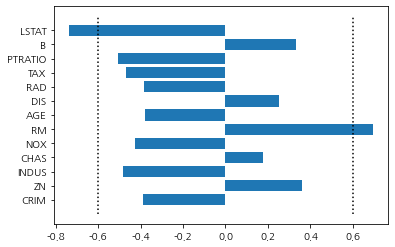

In [204]:
plt.barh(data['feature_names'], corr,)
plt.vlines(-.6, -1,13, linestyle=':', color='k')
plt.vlines(.6, -1,13, linestyle=':', color='k')
plt.show()

In [170]:
feat_num = -1
array = X[:,feat_num].copy()

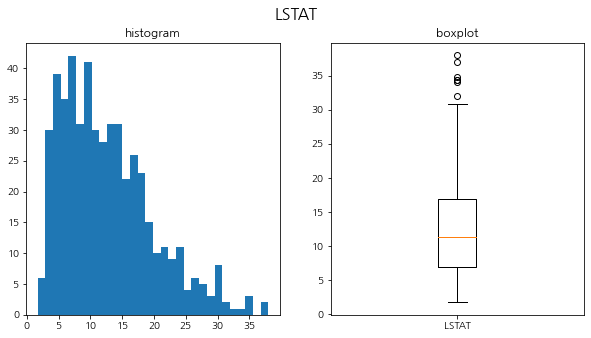

In [171]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.hist(array, bins=30)
ax1.set_title('histogram')
ax2 = fig.add_subplot(122)
ax2.boxplot(array, )
ax2.set_xticklabels([data['feature_names'][feat_num]])
ax2.set_title('boxplot')
fig.suptitle(data['feature_names'][feat_num], fontsize=16)
plt.show()

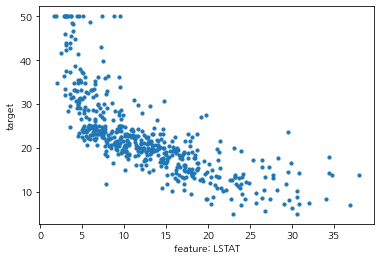

In [172]:
plt.scatter(array, y, s = 10)
plt.xlabel('feature: {}'.format(data['feature_names'][feat_num]))
plt.ylabel('target')
plt.show()

# Box-Cox

## Log likelihood function

* Approximately

$\large \displaystyle \begin{align*} l(\lambda) &= (\lambda - 1)\sum_{i}^{n} \log(x_i) - \frac{n}{2} \log(\mathrm{Var}(\mathbf{y})) \\
&= (\lambda - 1)\sum_{i}^{n} \log(x_i) - \frac{n}{2} \log(\frac{1}{n} \sum_{i}^{n}(y_i - \bar{y})^2) 
\end{align*}$ 

where $\large  \mathbf{y} = \begin{cases} \frac{\mathbf{x}^{\lambda} -1 }{\lambda}, &\lambda \ne 0\\ \log(\mathbf{x}), &\lambda = 0 \end{cases}$

In [173]:
lmbdas = np.linspace(-1,1, 10000)
llf = np.array([boxcox_llf(l, array) for l in lmbdas])

In [174]:
def _eval_mle(lmb, data):
    # refer to https://github.com/scipy/scipy/blob/master/scipy/stats/morestats.py#L1221
    return -boxcox_llf(lmb, data)

mx, my, _, _ = brent(_eval_mle, args = (array,), full_output=True, brack = (-2,2))

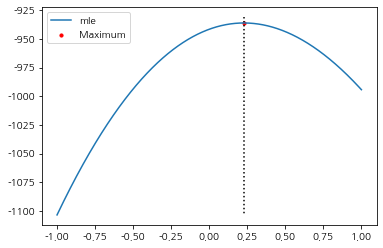

In [196]:
fig, ax = plt.subplots(1,1, )
ax.vlines(mx, -my +5, llf.min(), linestyle=':', color = 'k')
ax.plot(lmbdas, llf, label= 'mle')
ax.scatter(mx, -my, s=10, color='r', label = 'Maximum')
plt.legend()
plt.show()

In [197]:
print(mx, my)

0.22776736893884023 936.0000020256239


* Finding the proper $\lambda$

In [198]:
lmbda_optimal = boxcox_normmax(array, method='all')
lmbda_optimal

array([0.23939438, 0.22776737])

```
lmbda_optimal[0]: by pearson r
lmbda_optimal[1]: by mle
```

## Transformed data

In [178]:
array1, lmbda = boxcox(array)

In [180]:
lmbda

0.22776736893884023

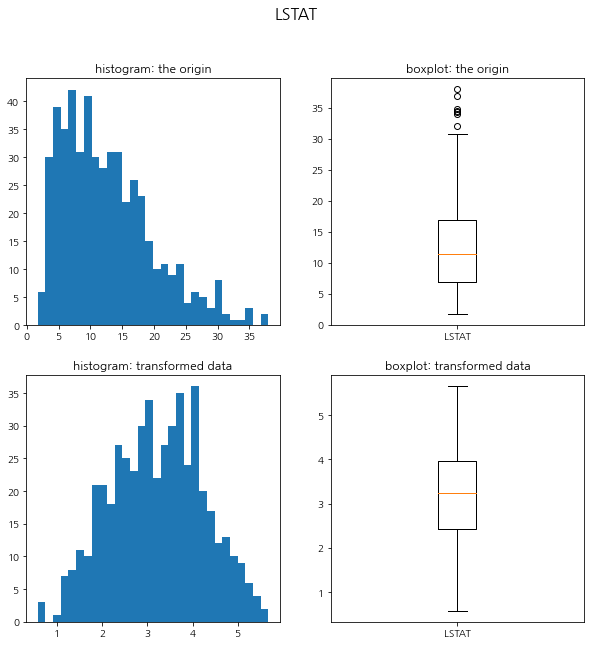

In [183]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
ax1.hist(array, bins=30)
ax1.set_title('histogram: the origin')
ax2 = fig.add_subplot(222)
ax2.boxplot(array, )
ax2.set_xticklabels([data['feature_names'][feat_num]])
ax2.set_title('boxplot: the origin')


ax3 = fig.add_subplot(223)
ax3.hist(array1, bins=30)
ax3.set_title('histogram: transformed data')
ax4 = fig.add_subplot(224)
ax4.boxplot(array1, )
ax4.set_xticklabels([data['feature_names'][feat_num]])
ax4.set_title('boxplot: transformed data')

fig.suptitle(data['feature_names'][feat_num], fontsize=16)
plt.show()

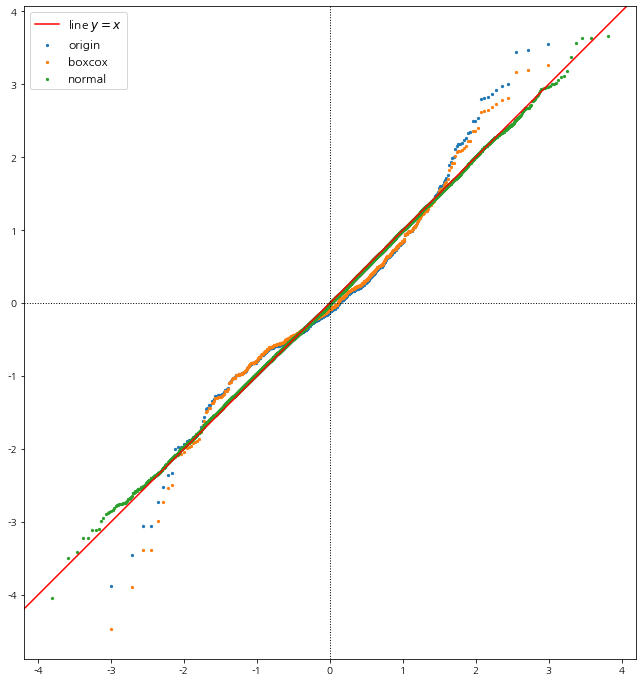

In [126]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
ax.set_aspect(1)
ax.scatter(val[0], val[1], s=5, label='origin')
#ax.axline((0, sl[1]), slope=sl[0])
ax.scatter(values[0], values[1], s=5, label='boxcox')
#ax.axline((0, slope[1]), slope=slope[0], color = 'orange')
ax.scatter(value[0], value[1], s=5, label='normal')
ax.axline((0,0), (1,1), color='r', label='line $y=x$')
ax.axline((0,0), (0,1), linestyle=':', linewidth=1, color='k')
ax.axline((0,0), (1,0), linestyle=':', linewidth=1, color='k')
plt.legend(fontsize=12)
plt.show()

In [64]:
def filliben(n):
    result = np.zeros(n)
    result[-1] = 0.5**(1./n)
    result[0] = 1 - 0.5**(1./n)
    for i in range(2, n):
        result[i-1] = (i - 0.3175) / (n + 0.365)
    return result

In [51]:
.5**(1/10000)

0.9999306876841536

In [52]:
filliben(10000)[-1]

0.9999306876841536

In [48]:
np.allclose(ndtri(filliben(10000)),value[0])

False

In [53]:
np.diff(np.arange(4))

array([1, 1, 1])

In [59]:
n= 4
v = np.empty(n, dtype=np.float64)
v[-1] = 0.5**(1.0 / n)
v[0] = 1 - v[-1]
i = np.arange(2, n)
v[1:-1] = (i - 0.3175) / (n + 0.365)

In [62]:
v

array([0.15910358, 0.38545246, 0.61454754, 0.84089642])

In [65]:
filliben(4)

array([0.15910358, 0.38545246, 0.61454754, 0.84089642])

In [68]:
np.allclose(ndtri(filliben(10000)), value[0])

True

In [67]:
value[0]

array([-3.81060943, -3.58545756, -3.46184782, ...,  3.46184782,
        3.58545756,  3.81060943])

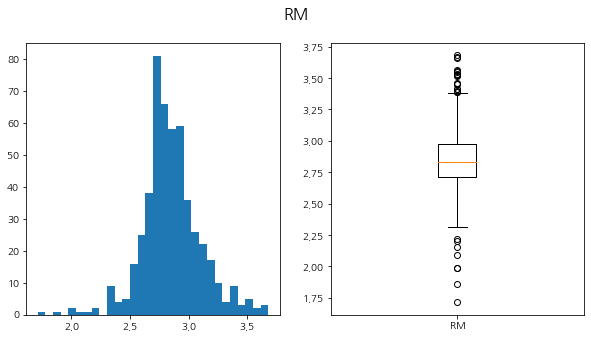

In [284]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.hist(array1, bins=30)
ax2 = fig.add_subplot(122)
ax2.boxplot(array1, )
ax2.set_xticklabels([data['feature_names'][5]])
fig.suptitle(data['feature_names'][5], fontsize=16)
plt.show()

In [48]:
def _eval_mle(lmb, data):
    # function to minimize
    return -boxcox_llf(lmb, data)

In [68]:
x = np.arange(-2,2,1/10000)
y = np.array([_eval_mle(i, array) for i in x])

In [135]:
n= array.shape[0]
v = np.empty(n, dtype=np.float64)
v[-1] = 0.5**(1.0 / n)
v[0] = 1 - v[-1]
i = np.arange(2, n)
v[1:-1] = (i - 0.3175) / (n + 0.365)

In [136]:
xvals = ndtri(v)

In [138]:
from scipy.stats import pearsonr
def _eval_pearsonr(lmbda, xvals, samps):
    # This function computes the x-axis values of the probability plot
    # and computes a linear regression (including the correlation) and
    # returns ``1 - r`` so that a minimization function maximizes the
    # correlation.
    y = boxcox(samps, lmbda)
    yvals = np.sort(y)
    r, prob = pearsonr(xvals, yvals)
    return 1 - r

In [167]:
brent(_eval_pearsonr, args=(xvals, array), brack=(-2,2), full_output=True)

(0.5566626745343906, 0.0191060851994469, 16, 20)

In [168]:
1- 0.0191060851994469

0.9808939148005531

In [141]:
boxcox_normmax(array, method='all')

array([0.55666267, 0.44895979])

In [90]:
np.empty(n, dtype=np.float64)

array([2.5, 2. , 1.5, 1. , 0.5, 0.5, 1. , 1.5, 2. , 2.5])

In [91]:
from scipy.special import ndtr, ndtri

In [143]:
x = np.arange(0, 1,1/10000)
y = ndtri(x)

In [133]:
x = np.arange(-2, 5,1/10000)
y = np.vectorize(lambda x: 1- np.exp(-x))(x)

In [213]:
pearsonr(xvals, np.sort(boxcox(array, lmbda = boxcox_normmax(array, method='all')[0])))

(0.9808939148005531, 0.0)

In [214]:
pearsonr(xvals, np.sort(boxcox(array, lmbda = boxcox_normmax(array, method='all')[1])))

(0.9808004073538887, 0.0)

In [223]:
ndtri(.95)

1.6448536269514722

In [227]:
ndtr(2.58) - ndtr(-2.58)

0.9901199684844586

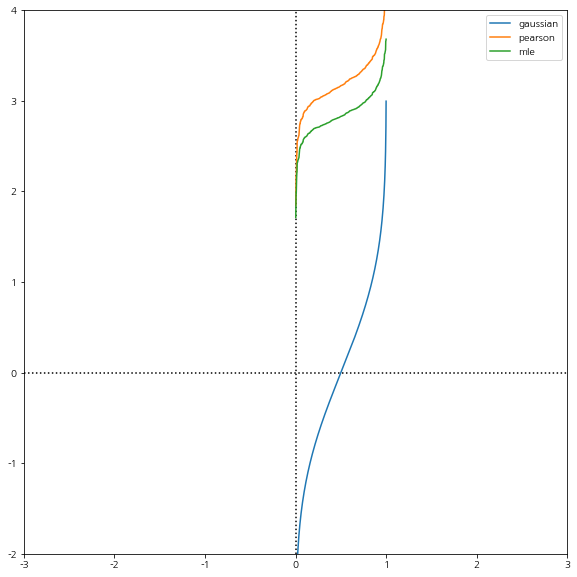

In [221]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.vlines(0., -2, 4, linestyle=':', color='k')
ax.hlines(0., -3, 3, linestyle=':', color='k')
ax.set_xlim(-3,3)
ax.set_ylim(-2,4)
ax.set_aspect(1)
#ax.plot(x,y,)
ax.plot(v, xvals, label = 'gaussian')
ax.plot(v, np.sort(boxcox(array, lmbda = boxcox_normmax(array, method='all')[0])),  label='pearson' )
ax.plot(v, np.sort(boxcox(array, lmbda = boxcox_normmax(array, method='all')[1])),  label='mle' )
ax.legend()
plt.show()

In [51]:
boxcox_normmax(array, method='all')

array([0.55666267, 0.44895979])

In [42]:
boxcox_llf(lmbda, array)

181.72324851014986

In [49]:
brent(_eval_mle, args=(array,), brack=(-2,2), full_output=True)

(0.4489597919730037, -181.72324851014986, 14, 18)

In [43]:
array1, lmbda =boxcox(array)
print(lmbda)

0.4489597919730037


In [52]:
array1 =boxcox(array, lmbda=boxcox_normmax(array, method='all')[0])

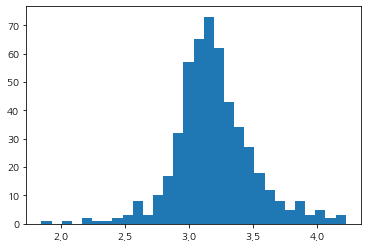

In [57]:
plt.hist(array1, bins=30)
plt.show()

In [55]:
array1.std()

0.3100360003242992

In [59]:
ar = np.random.normal(size = array1.shape[0] )

In [58]:
shapiro(array1)

ShapiroResult(statistic=0.9640697240829468, pvalue=8.737852108531285e-10)

In [60]:
f_oneway(array1, ar)

F_onewayResult(statistic=4724.003558825085, pvalue=0.0)

In [51]:
np.quantile(array, q = [.25,.75])

array([0.082045 , 3.6770825])

In [53]:
iqr*1.5+q3

9.06963875

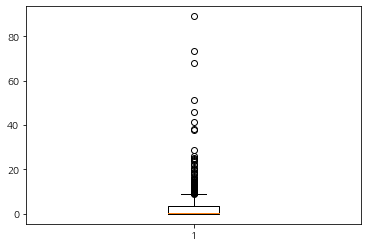

In [234]:
plt.boxplot(array)
plt.show()

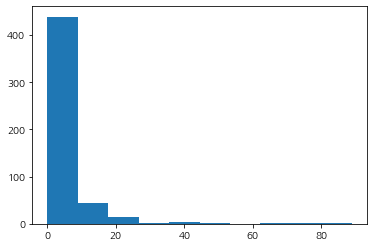

In [236]:
plt.hist(array)
plt.show()